In [2]:
!pip install bing_image_downloader

## Cargar imagenes

In [27]:
from bing_image_downloader import downloader
import os
import shutil

# Define los términos de búsqueda y la cantidad de imágenes a descargar para cada uno
search_terms = ['perro', 'flor', 'zapato']
total_images_per_term = 300
# Crea una carpeta base para almacenar las imágenes
output_dir = 'dataset'



if not os.path.exists(output_dir):
    os.makedirs(output_dir)
else:
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)

# Función para renombrar y mover las imágenes descargadas
def rename_and_move_images(term, output_dir, count):
    term_dir = os.path.join(output_dir, term)
    images = os.listdir(term_dir)

    for idx, image in enumerate(images):

        base_name, extension = os.path.splitext(image)

        # Generar el nuevo nombre usando la extensión original
        new_name = f"{term}_{count + idx + 1}{extension}"
        os.rename(os.path.join(term_dir, image), os.path.join(output_dir, new_name))

    # Elimina la carpeta del término original
    shutil.rmtree(term_dir)

# Descargar y renombrar imágenes para cada término de búsqueda
for term in search_terms:
    downloader.download(term, limit=total_images_per_term, output_dir=output_dir, adult_filter_off=False, force_replace=False, timeout=60)
    rename_and_move_images(term, output_dir, 0)

print("Descarga y renombrado de imágenes completado.")


Se han truncado las últimas 5000 líneas del flujo de salida.

[%] Downloading Image #196 from https://cdn.redcanina.es/wp-content/uploads/2021/05/24105907/perro-salchicha.jpg
[%] File Downloaded !

[%] Downloading Image #197 from https://i.pinimg.com/originals/5b/9a/f2/5b9af212344e03f8eb72c72aa2eaaf86.jpg
[%] File Downloaded !

[%] Downloading Image #198 from https://i0.wp.com/planetamascotaperu.com/wp-content/uploads/2022/12/0dd985_5dcc9f042b364ce3be98e354c2248d9f_mv2-1.jpg?fit=1000%2C667&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #199 from https://i1.wp.com/www.capitalmexico.com.mx/wp-content/uploads/2018/07/perros-callejeros.jpg?fit=1200%2C620&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #200 from https://i.pinimg.com/originals/b9/81/0a/b9810a8729e2100be1d5969c67e2fa79.jpg
[%] File Downloaded !

[%] Downloading Image #201 from https://petfamily.com.co/wp-content/uploads/2022/07/PERROS-GUIAS-LAZARILLOS-DISCAPACIDAD-VISUAL-PET-FAMILY-1.jpeg
[%] File Downloaded !


KeyboardInterrupt: 

## Preprocesamiento de imagenes

In [16]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_and_preprocess_images(folder_path, size=(224, 224)):
    images = []
    paths = []
    for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      print(f"Procesando: {file_path}")  # Depuración
      img = cv2.imread(file_path)
      if img is not None:
        img = cv2.resize(img, size)  # Normalizar tamaño
        img = np.float32(img) / 255.0  # Normalización
        images.append(img)
        paths.append(file_path)
      else:
        print(f"No se pudo leer la imagen: {file_path}")

    # Convertir la lista de imágenes a un array de numpy y cambiar la forma
    images = np.array(images)
    images = images.reshape(len(images), -1)  # Cambio de forma
    return images, paths

folder_path = 'dataset'
images, paths = load_and_preprocess_images(folder_path)

#pickle.dump(files, open( "raw_images.pkl", "wb" ) )


Procesando: dataset/flor_50.jpg
Procesando: dataset/perro_104.jpg
Procesando: dataset/flor_64.jpg
Procesando: dataset/flor_12.jpg
Procesando: dataset/zapato_17.jpg
Procesando: dataset/zapato_139.png
Procesando: dataset/zapato_129.jpg
Procesando: dataset/zapato_33.jpeg
Procesando: dataset/flor_6.png
Procesando: dataset/perro_74.jpg
Procesando: dataset/flor_43.jpg
Procesando: dataset/zapato_48.jpg
Procesando: dataset/zapato_148.jpg
Procesando: dataset/perro_7.jpg
Procesando: dataset/perro_67.jpg
Procesando: dataset/zapato_122.jpg
Procesando: dataset/zapato_115.jpg
Procesando: dataset/zapato_61.jpg
Procesando: dataset/zapato_143.png
Procesando: dataset/flor_51.jpg
Procesando: dataset/flor_109.jpg
Procesando: dataset/perro_95.jpg
Procesando: dataset/zapato_24.jpg
Procesando: dataset/perro_103.webp
Procesando: dataset/perro_140.jpg
Procesando: dataset/perro_122.jpg
Procesando: dataset/zapato_142.jpg
Procesando: dataset/flor_60.JPG
Procesando: dataset/perro_2.png
Procesando: dataset/perro_13

## Extraccion de caracteristicas

In [18]:
import tensorflow as tf
import pickle

#images = pickle.load( open( "preprocessed_images.pkl", "rb" ) )
model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
predictions = model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)

15/15 [==============================] - 26s 2s/step


## Prediccion

In [19]:

from sklearn.cluster import KMeans

# Clustering final
k = 3
kmodel = KMeans(n_clusters=k, random_state=728)
kmodel.fit(pred_images)
kpredictions = kmodel.predict(pred_images)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


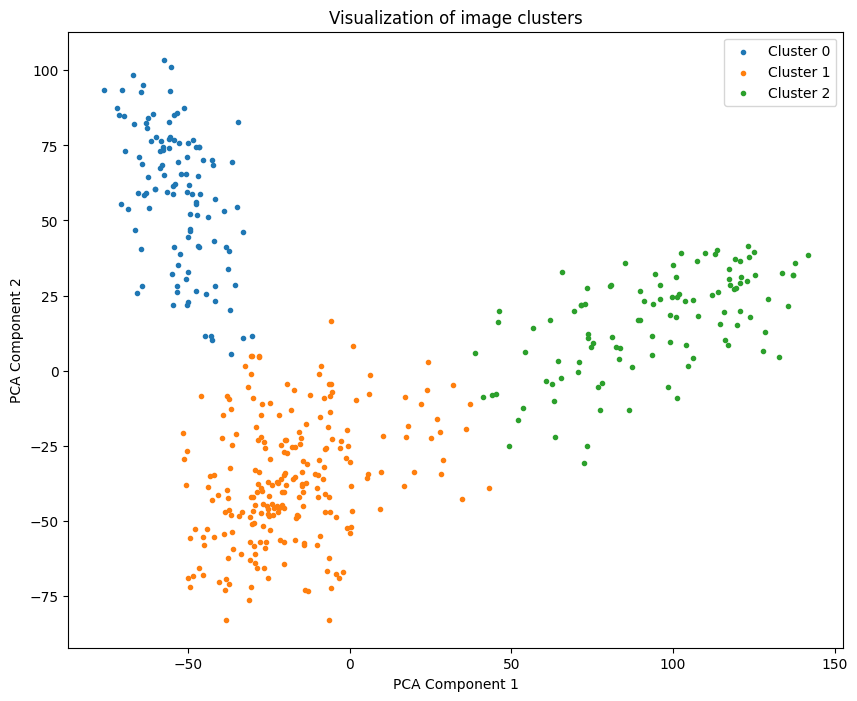

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pred_images)

plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(pca_result[kpredictions == i, 0], pca_result[kpredictions == i, 1], label=f'Cluster {i}', marker='.')
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualization of image clusters')
plt.show()

## Evaluacion de resultados

In [26]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluar la calidad del clustering
silhouette_avg = silhouette_score(pred_images, kpredictions)
calinski_harabasz = calinski_harabasz_score(pred_images, kpredictions)
davies_bouldin = davies_bouldin_score(pred_images, kpredictions)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.023940615355968475
Calinski-Harabasz Index: 15.57168217788693
Davies-Bouldin Index: 4.707097823853312


In [21]:
base_dir = 'output'


if os.path.exists(base_dir):
  shutil.rmtree(base_dir)

os.makedirs(base_dir)
for i in range(k):
	os.makedirs(base_dir + "/cluster" + str(i))
for i in range(len(paths)):
	shutil.copy2(paths[i], base_dir + "/cluster"+str(kpredictions[i]))

In [25]:
def find_all_classes(cluster_n):
  flores = [ flor for flor in cluster_n if 'flor' in flor]
  perros = [ perro for perro in cluster_n if 'perro' in perro]
  zapatos = [ zapato for zapato in cluster_n if 'zapato' in zapato]

  return flores, perros, zapatos

cluster0 = os.listdir(base_dir + '/cluster0')
cluster1 = os.listdir(base_dir + '/cluster1')
cluster2 = os.listdir(base_dir + '/cluster2')


flores0, perros0, zapatos0 = find_all_classes(cluster0)
print("------------- Cluster 0")
print("Flores: ", len(flores0))
print("Carros: ", len(perros0))
print("Zapatos: ", len(zapatos0))

flores1, perros1, zapatos1 = find_all_classes(cluster1)
print("------------- Cluster 1")
print("Flores: ", len(flores1))
print("Carros: ",len(perros1))
print("Zapatos: ", len(zapatos1))

flores2, perros2, zapatos2 = find_all_classes(cluster2)
print("------------- Cluster 2")
print("Flores: ", len(flores2))
print("Carros: ", len(perros2))
print("Zapatos: ", len(zapatos2))

------------- Cluster 0
Flores:  114
Carros:  0
Zapatos:  0
------------- Cluster 1
Flores:  36
Carros:  150
Zapatos:  41
------------- Cluster 2
Flores:  0
Carros:  0
Zapatos:  108
